In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import structure

In [2]:
import random
tseed = random.randint(0, 10000)
random.seed(5*tseed)
np.random.seed(tseed)
print(f"seed: {tseed}")
defaultclock.dt = 0.1 * ms

seed: 8031


In [ ]:
# NE = 800         # Number of excitatory cells
NE = 784
NP = 100         # number of PV cells (symmetric iSTDP)
NS = 100         # number of SST cells (antisymmetric iSTDP)

# simulation time
time_warmup = 3.0 # Warmup time (seconds)
time_eerun = 120.0 # EE run time (seconds)
time_training = 120.0 # Simulation time (seconds)
time_checkspikes = 60.0 # record spikes of exc population here

# ###########################################
# Neuron model
# ###########################################
tau_ampa = 5.0 # Glutamatergic synaptic time constant (ms)
tau_gaba = 10.0 # GABAergic synaptic time constant (ms)
gl = 10.0
el = -60.0
er = -80.0
vt = -50.0
memc = 200.0  # Membrane capacitance
# background currents
bg_current_e = 1000.0 # External current (pA)
bg_current_p = 0.0
bg_current_s = 0.0
# noisy input for exc
n_input_e = 200
rate_input_e = 80 # (Hz)
strength_input_e = 1.0 # (mV)
# noisy input for PV
n_input_p = 200
rate_input_p = 40 # (Hz)
strength_input_p = 1.0 # (mV)
# noisy input for SST
n_input_s = 200
rate_input_s = 40 # (Hz)
strength_input_s = 1.0 # (mV)
    
# connection sparseness (inh. only)
connprob_sp = 0.9
connprob_ss = 0.9
connprob_ps = 0.9
connprob_pp = 0.9
# ring parameters (lower is broader)
k_ring_ee=10.0 
k_ring_ep=5.0 
k_ring_es=10.0 
# connection weights
w_ee_sum = 145.0 # exc to exc, SUM
w_ep_sum,w_es_sum = 145.0,145.0 # exc to inh SUM
w_ps,w_sp = 1.0,1.0
w_ss,w_pp = 2.5,2.5
w_pe,w_se = 3.0,3.0 # the plastic ones
w_ee = 1.0 # excitatory plastic ones

w_ep,w_es = 1.0,1.0 # inhibitory plastic ones

# Maximum inhibitory weight
weigh_max = 80
w_max_ei = weigh_max

A0learn_e = 1E-3

# STDP parameters for PV to exc
A0learn_p = 2E-3
# A0learn_p = 2E-2
theta_p = -1.0
gamma_p = 20.0
alpha_pre_p = -0.2
alpha_post_p = 1.0
tauplus_stdp_p = 30.0    # STDP time constant (ms)

# STDP parameters for SST to exc
A0learn_s = 1E-3
# A0learn_s = 1E-2
theta_s = -1.0
gamma_s = 1.0
alpha_pre_s = -0.2
alpha_post_s = 1.0
tauplus_stdp_s = 30.0    # STDP time constant (ms)

# E-I plasticity parameters
A0learn_ep = A0learn_s 
A0learn_es = A0learn_p

# Simulation details
save_id = 'torus_structure_two_interneurons'

In [4]:
Lx, Ly = 1.0, 1.0 

pos_e = structure.assign_positions_2d(NE, Lx, Ly)
pos_p = structure.assign_positions_2d(NP, Lx, Ly)
pos_s = structure.assign_positions_2d(NS, Lx, Ly)

sx_ee = sy_ee = 0.02   # E->E
sx_ep = sy_ep = 0.10   # E->PV
sx_es = sy_es = 0.10   # E->SST

print(f"sx_ee: {sx_ee:2f}, sy_ee: {sy_ee:2f}")
print(f"sx_ep: {sx_ep:2f}, sy_ep: {sy_ep:2f}")
print(f"sx_es: {sx_es:2f}, sy_es: {sy_es:2f}")

rmax_ee = None
rmax_ep = None
rmax_es = None

w_thresh_torus = 1e-6

sx_ee: 0.020000, sy_ee: 0.020000
sx_ep: 0.100000, sy_ep: 0.100000
sx_es: 0.100000, sy_es: 0.100000


In [5]:
dt_patch = 100.0 * ms                 
patch_sigma_x = 0.03     
patch_sigma_y = 0.03              
print(f"patch_sigma_x: {patch_sigma_x:2f}, Lx/np.sqrt(NE): {Lx/np.sqrt(NE):.2f}")  
patch_radius  = 2.5 * patch_sigma_x  
patch_rate_inside   = rate_input_e * 1.0
base_rate_outside   = 0

rng_patch = np.random.default_rng(1234 + tseed)

def _torus_dist_to_point(P, center, Lx=1.0, Ly=1.0):
    dx = (P[:, 0] - center[0] + Lx/2) % Lx - Lx/2
    dy = (P[:, 1] - center[1] + Ly/2) % Ly - Ly/2
    return np.sqrt(dx*dx + dy*dy)

nsteps_ee = int(np.ceil((time_eerun*second) / dt_patch))
rates_EE  = np.full((nsteps_ee, NE), base_rate_outside * n_input_e, dtype=float)  # Hz
patch_gate = np.zeros((nsteps_ee, NE), dtype=float)

for k in range(nsteps_ee):
    c = rng_patch.integers(NE) 
    R = _torus_dist_to_point(pos_e, pos_e[c], Lx=Lx, Ly=Ly)
    mask = R <= patch_radius
    rates_EE[k, mask] = n_input_e * patch_rate_inside  
    patch_gate[k, mask] = 1.0
    
rates_EE_ta = TimedArray(rates_EE * Hz, dt=dt_patch)
patch_gate_ta = TimedArray(patch_gate, dt=dt_patch)
t_EE_on  = (time_warmup + time_checkspikes) * second
t_EE_off = t_EE_on + time_eerun * second
T_last   = (nsteps_ee - 1) * dt_patch

patch_sigma_x: 0.030000, Lx/np.sqrt(NE): 0.04


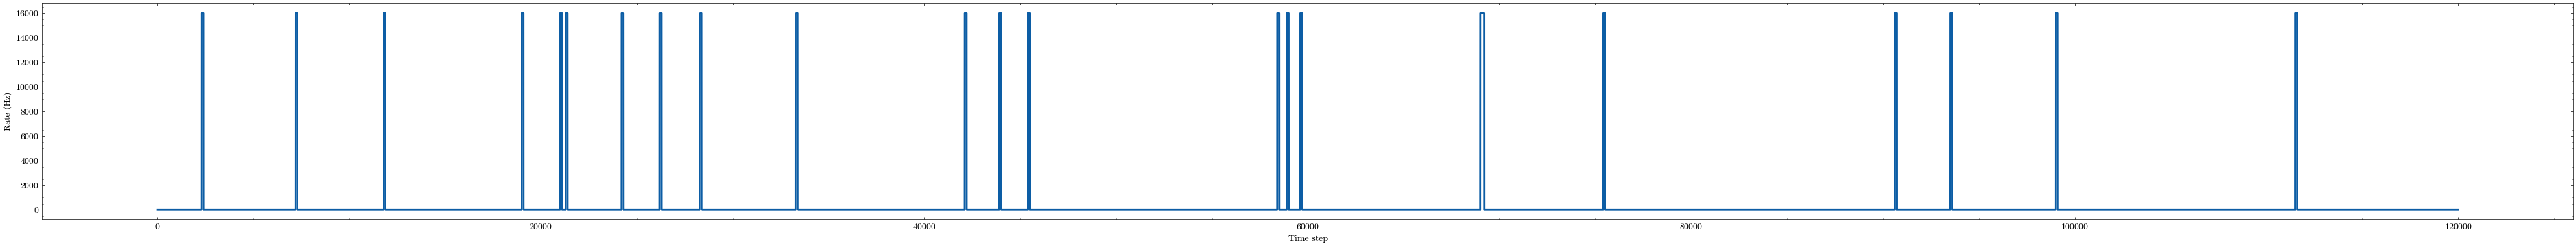

In [6]:
# plot the patched input on arbitrary exctitatory neuron
rate = [int(rates_EE_ta(i*ms,0)) for i in range(int(time_eerun * 1000))]
fig, ax = plt.subplots(figsize=(40,4))
ax.plot(rate, linewidth=2)
ax.set_xlabel('Time step')
ax.set_ylabel('Rate (Hz)')
fig.tight_layout()

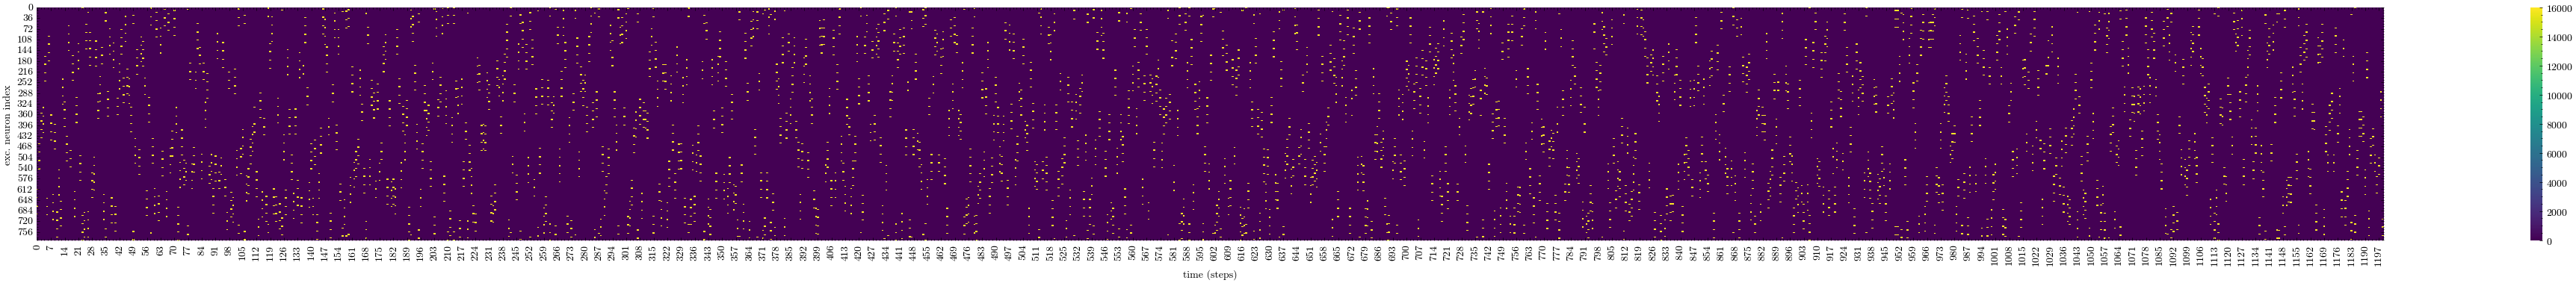

In [7]:
fig, ax = plt.subplots(1,1,figsize=(40,4))
sns.heatmap(rates_EE.T, ax=ax, cmap='viridis')
ax.set_xlabel('time (steps)')
ax.set_ylabel('exc. neuron index')
fig.tight_layout()

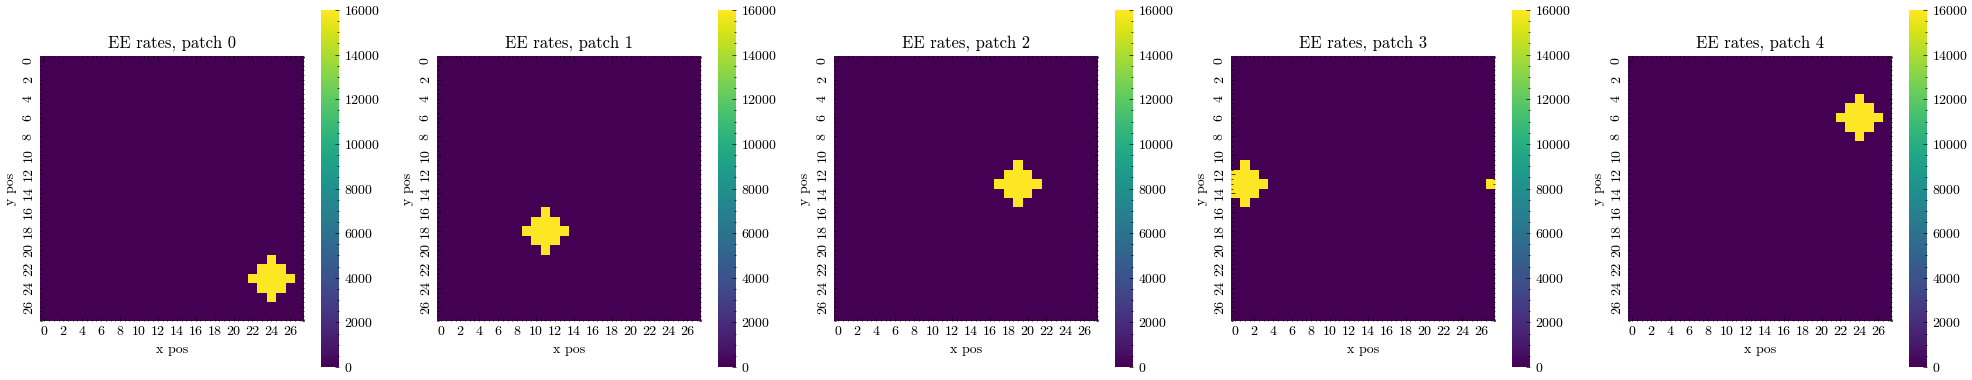

In [8]:
sqrtne = int(np.sqrt(NE))
plotnum = 5
fig, axs = plt.subplots(1,plotnum,figsize=(4*plotnum,4))
for i in range(plotnum):
    sns.heatmap(rates_EE[i,:].reshape(sqrtne, sqrtne), ax=axs[i], cmap='viridis', square=True)
    axs[i].set_title(f"EE rates, patch {i}")
    axs[i].set_xlabel('x pos')
    axs[i].set_ylabel('y pos')
fig.tight_layout()

In [9]:
# E->E STDP parameters
A_p = 0.08        
# A_d = -0.0533
# A_d = -0.066     
A_d = -0.04    
tau_p = 0.025*second
# tau_p = 0.035*second
tau_d = 0.050*second
w_max_ee = weigh_max  

In [10]:
print(f'NE is {NE}, NP is {NP}, NS is {NS}')

eqs_neurons_e='''
    input_contrast : 1
    dv/dt=(-(gl*nsiemens)*(v-el*mV)-(g_ampa*v+g_gaba*(v-er*mV))+bg_current_e*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_p='''
    dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_p*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_s='''
    dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_s*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

# ###########################################
# Initialize neuron group
# ###########################################
Pe = NeuronGroup(NE, model=eqs_neurons_e, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Pp = NeuronGroup(NP, model=eqs_neurons_p, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Ps = NeuronGroup(NS, model=eqs_neurons_s, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')

PIe_IE_period = PoissonInput(Pe, 'g_ampa', n_input_e, rate_input_e*Hz, weight=strength_input_e*nS) 
PIe_EE_period = PoissonInput(Pe, 'g_ampa', n_input_e, (1 * rate_input_e)*Hz, weight=strength_input_e*nS)
PIe_EE_period.active = False 

PIp = PoissonInput(Pp, 'g_ampa', n_input_p, rate_input_p*Hz, weight=strength_input_p*nS)
PIs = PoissonInput(Ps, 'g_ampa', n_input_s, rate_input_s*Hz, weight=strength_input_s*nS)

# patches input
Ge_EE_patch = PoissonGroup(
    NE,
    rates='(t >= t_on) * (t < t_off) * ratesEE(clip(t - t_on, 0*second, T_last), i)',
    namespace={'t_on': t_EE_on, 't_off': t_EE_off, 'ratesEE': rates_EE_ta, 'T_last': T_last}
)

Ie_EE_patch = Synapses(
    Ge_EE_patch, Pe,
    model='w_patch : siemens',
    on_pre='g_ampa_post += w_patch',
    name='Ie_EE_patch'
)
Ie_EE_patch.connect(j='i')  

Ie_EE_patch.w_patch = (n_input_e * strength_input_e) * nS  
print('Patch synapses N =', Ie_EE_patch.N)

NE is 784, NP is 100, NS is 100


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    'i' is an internal variable of group 'Ie_EE_patch', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Patch synapses N = <Ie_EE_patch.N: 784>


In [11]:
# ##########################################
# Connecting the network
# ###########################################

# exc to exc and to inh
# con_ee = Synapses(Pe, Pe,model='w:1', on_pre='g_ampa += w*nS') 
# con_ep = Synapses(Pe, Pp,model='w:1', on_pre='g_ampa += w*nS')
# con_es = Synapses(Pe, Ps,model='w:1', on_pre='g_ampa += w*nS')

# inh to inh 
con_ps = Synapses(Pp, Ps, on_pre='g_gaba += w_ps*nS')
con_sp = Synapses(Ps, Pp, on_pre='g_gaba += w_sp*nS')
con_pp = Synapses(Pp, Pp, on_pre='g_gaba += w_pp*nS')
con_ss = Synapses(Ps, Ps, on_pre='g_gaba += w_ss*nS')

# ###########################################
# Inhibitory to inhibitory connections
# ###########################################
con_sp.connect(p=connprob_sp)
con_ps.connect(p=connprob_ps)
con_pp.connect(p=connprob_pp)
con_ss.connect(p=connprob_ss)

# ###################################################
# Excitatory connections implement the torus structure
# ##################################################

# E to E connections
W_ee, R_ee = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_e, wsum=w_ee_sum,
    sx=sx_ee, sy=sy_ee, Lx=Lx, Ly=Ly,
    r_max=rmax_ee, w_thresh=w_thresh_torus, avoid_self_connections=True
)

# E -> PV
W_ep, R_ep = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_p, wsum=w_ep_sum,
    sx=sx_ep, sy=sy_ep, Lx=Lx, Ly=Ly,
    r_max=rmax_ep, w_thresh=w_thresh_torus, avoid_self_connections=True
)

# E -> SST
W_es, R_es = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_s, wsum=w_es_sum,
    sx=sx_es, sy=sy_es, Lx=Lx, Ly=Ly,
    r_max=rmax_es, w_thresh=w_thresh_torus, avoid_self_connections=True
)

# ###########################################
# Inhibitory Plasticity
# ###########################################
A0_p = 0.0 # start with no learning
A0_s = 0.0 # start with no learning
A0_e = 0.0 # start with no learning
A0_ep = 0.0 # start with no learning
A0_es = 0.0 # start with no learning

# derived parameters
tauminus_stdp_p = gamma_p*tauplus_stdp_p
tauminus_stdp_s = gamma_s*tauplus_stdp_s

# NOT scaled by A0 here (since it controls learning on/off)
Aplus_p = float(1/tauplus_stdp_p)*1E3 # time was in ms, needs to be seconds
Aminus_p = float(theta_p/tauminus_stdp_p)*1E3
print(f"Aplus_p: {Aplus_p:2f}; Aminus_p: {Aminus_p:2f}")

Aplus_s = float(1/tauplus_stdp_s)*1E3
Aminus_s = float(theta_s/tauminus_stdp_s) *1E3
print(f"Aplus_s: {Aplus_s:2f}; Aminus_s: {Aminus_s:2f}")

# modify to let the SST kernel not perfectly antisymmetric
modify_amplitude = False
if modify_amplitude:
    amp_scale = 1.0
    Aplus_s_new = amp_scale * Aplus_s
    tauplus_stdp_s_new_ms = (-Aminus_s * tauminus_stdp_s) / Aplus_s_new 
    # overwrite the original values
    Aplus_s = float(Aplus_s_new)
    tauplus_stdp_s = float(tauplus_stdp_s_new_ms)

    area_pos = Aplus_s * tauplus_stdp_s         
    area_neg = Aminus_s * tauminus_stdp_s 
    print(f"area_pos: {area_pos:2f}; area_neg: {area_neg:2f}")

Aplus_p: 33.333333; Aminus_p: -1.666667
Aplus_s: 33.333333; Aminus_s: -33.333333


In [12]:
# simple traces for pre- and postsynaptic activity
# (that need to be rescaled)

eqs_stdp_inhib_p = '''
    w : 1
    dtrace_pre_plus/dt=-trace_pre_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
    dtrace_pre_minus/dt=-trace_pre_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
    dtrace_post_plus/dt=-trace_post_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
    dtrace_post_minus/dt=-trace_post_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
'''

con_pe = Synapses(Pp, Pe, model=eqs_stdp_inhib_p,
    on_pre='''
        trace_pre_plus += 1.0
        trace_pre_minus += 1.0
        w = clip(w + A0_p*(alpha_pre_p + Aplus_p*trace_post_plus + Aminus_p*trace_post_minus), 0, weigh_max)
        g_gaba += w*nS
    ''',
    on_post='''
        trace_post_plus += 1.0
        trace_post_minus += 1.0
        w = clip(w + A0_p*(alpha_post_p + Aplus_p*trace_pre_plus + Aminus_p*trace_pre_minus), 0, weigh_max)
    ''')
con_pe.connect()
con_pe.w = w_pe

    
eqs_stdp_inhib_s = '''
    w : 1
    dtrace_plus/dt=-trace_plus/(tauplus_stdp_s*ms) : 1 (event-driven)
    dtrace_minus/dt=-trace_minus/(tauminus_stdp_s*ms) : 1 (event-driven)
'''

con_se = Synapses(Ps, Pe, model=eqs_stdp_inhib_s,
    on_pre='''
        trace_plus += 1.0
        w = clip(w + A0_s*(alpha_pre_s + Aminus_s*trace_minus), 0, weigh_max)
        g_gaba += w*nS''',
    on_post='''
        trace_minus += 1.0
        w = clip(w + A0_s*(alpha_post_s + Aplus_s*trace_plus), 0, weigh_max)''')
con_se.connect()
con_se.w = w_se

# setting up the E->E connections
eqs_stdp_exc = '''
    w : 1
    dpre_fast/dt  = -pre_fast/tau_p : 1 (event-driven)
    dpre_slow/dt  = -pre_slow/tau_d : 1 (event-driven)
    dpost_fast/dt = -post_fast/tau_p : 1 (event-driven)
    dpost_slow/dt = -post_slow/tau_d : 1 (event-driven)
'''

con_ee = Synapses(
    Pe, Pe, model=eqs_stdp_exc,
    on_pre=f'''
        pre_fast += 1.0
        pre_slow += 1.0
        w = clip(w + A0_e*({A_p}*post_fast + {A_d}*post_slow), 0, {w_max_ee})
        g_ampa += w*nS
    ''',
    on_post=f'''
        post_fast += 1.0
        post_slow += 1.0
        w = clip(w + A0_e*({A_p}*pre_fast + {A_d}*pre_slow), 0, {w_max_ee})
    '''
)
idxee_pre, idxee_post, wvals_ee = structure.wmat_to_lists(W_ee)

con_ee.connect() # all-to-all connections
# con_ee.connect(i=idxee_pre, j=idxee_post) # use the torus topology

# con_ee.w = wvals_ee # whether to initialize the weight using the torus structure
con_ee.w = w_ee # uniform initial weights


# E-I connections
# E -> PV
con_ep = Synapses(
    Pe, Pp,
    model=eqs_stdp_inhib_s,  # trace_plus / trace_minus
    on_pre='''
        trace_plus += 1.0
        w = clip(w + A0_ep*(alpha_pre_s + Aminus_s*trace_minus), 0, w_max_ei)
        g_ampa += w*nS
    ''',
    on_post='''
        trace_minus += 1.0
        w = clip(w + A0_ep*(alpha_post_s + Aplus_s*trace_plus), 0, w_max_ei)
    ''',
    name='con_ep'
)

idxep_pre, idxep_post, wvals_ep = structure.wmat_to_lists(W_ep)
# con_ep.connect(i=idxep_pre, j=idxep_post)
con_ep.connect()  # all-to-all connections
# con_ep.w = wvals_ep
con_ep.w = w_ep  # uniform initial weights

# E -> SST
con_es = Synapses(
    Pe, Ps,
    model=eqs_stdp_inhib_p,  # trace_pre_plus/minus & trace_post_plus/minus
    on_pre='''
        trace_pre_plus  += 1.0
        trace_pre_minus += 1.0
        w = clip(w + A0_es*(alpha_pre_p + Aplus_p*trace_post_plus + Aminus_p*trace_post_minus), 0, w_max_ei)
        g_ampa += w*nS
    ''',
    on_post='''
        trace_post_plus  += 1.0
        trace_post_minus += 1.0
        w = clip(w + A0_es*(alpha_post_p + Aplus_p*trace_pre_plus + Aminus_p*trace_pre_minus), 0, w_max_ei)
    ''',
    name='con_es'
)

idxes_pre, idxes_post, wvals_es = structure.wmat_to_lists(W_es)
# con_es.connect(i=idxes_pre, j=idxes_post)
con_es.connect()  # all-to-all connections
# con_es.w = wvals_es
con_es.w = w_es  # uniform initial weights

# ###########################################
# Setting up monitors
# ###########################################

# population rates
pop_re_mon = PopulationRateMonitor(Pe)
pop_rp_mon = PopulationRateMonitor(Pp)
pop_rs_mon = PopulationRateMonitor(Ps)
    
# exc spikes
spk_e_mon = SpikeMonitor(Pe)
# pv spikes
spk_p_mon = SpikeMonitor(Pp)
# sst spikes
spk_s_mon = SpikeMonitor(Ps)
    
spk_e_mon.active=False
spk_p_mon.active=False
spk_s_mon.active=False

pop_re_mon.active=False
pop_rp_mon.active=False
pop_rs_mon.active=False

sp_in = SpikeMonitor(Ge_EE_patch, name='sp_ge_in')

In [13]:
# about weight monitors
sample_every = 60.0 * second
wt_clock = Clock(dt=sample_every)

record_all = True 
subset_per_pathway = 500

def pick_subset(syn, k):
    Nsyn = syn.N
    k = min(k, Nsyn)
    rng = np.random.default_rng(1234)
    return np.sort(rng.choice(Nsyn, size=k, replace=False))

rec_ee = True if record_all else pick_subset(con_ee, subset_per_pathway)
rec_pe = True if record_all else pick_subset(con_pe, subset_per_pathway)
rec_se = True if record_all else pick_subset(con_se, subset_per_pathway)
rec_ep = True if record_all else pick_subset(con_ep, subset_per_pathway)
rec_es = True if record_all else pick_subset(con_es, subset_per_pathway)

mon_w_ee_EE = StateMonitor(con_ee, 'w', record=rec_ee,  clock=wt_clock, name='mon_w_ee_EE')
mon_w_pe_IE = StateMonitor(con_pe, 'w', record=rec_pe,  clock=wt_clock, name='mon_w_pe_IE')
mon_w_se_IE = StateMonitor(con_se, 'w', record=rec_se,  clock=wt_clock, name='mon_w_se_IE')
mon_w_ep_EI = StateMonitor(con_ep, 'w', record=rec_ep,  clock=wt_clock, name='mon_w_ep_EI')
mon_w_es_EI = StateMonitor(con_es, 'w', record=rec_es,  clock=wt_clock, name='mon_w_es_EI')

mon_w_ee_EE.active = False
mon_w_pe_IE.active = False
mon_w_se_IE.active = False
mon_w_ep_EI.active = False
mon_w_es_EI.active = False

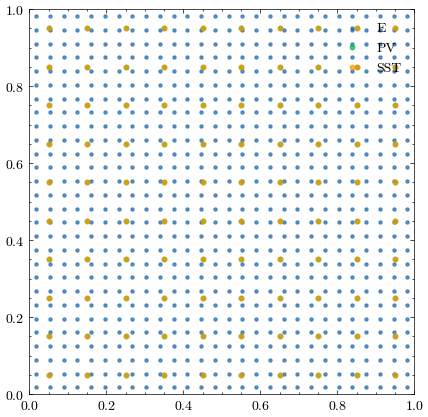

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(pos_e[:,0], pos_e[:,1], s=5, label='E', alpha=0.6)
ax.scatter(pos_p[:,0], pos_p[:,1], s=10, label='PV', alpha=0.7)
ax.scatter(pos_s[:,0], pos_s[:,1], s=10, label='SST', alpha=0.7)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
fig.gca().set_aspect('equal', adjustable='box')
ax.legend()
fig.savefig(f"../Figures/torus_positions_seed{tseed}.png", dpi=300)

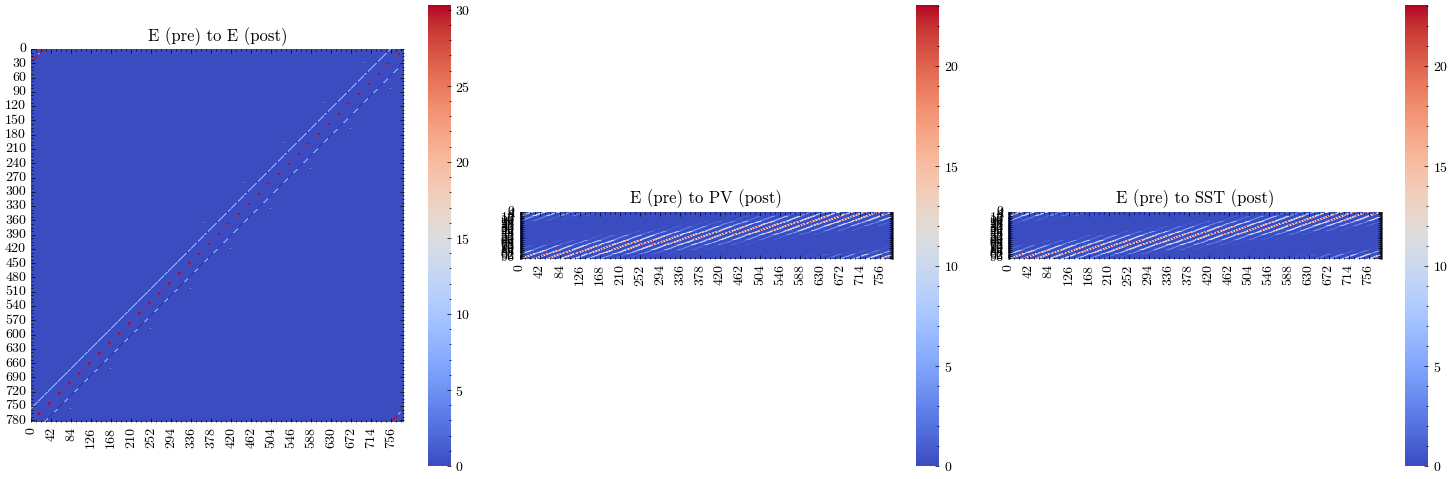

In [15]:
ext_ext_init_weights = np.zeros((NE, NE))
for i in range(len(idxee_pre)):
    ext_ext_init_weights[idxee_pre[i], idxee_post[i]] = wvals_ee[i]
    
ext_pv_init_weights = np.zeros((NE, NP))
for i in range(len(idxep_pre)):
    ext_pv_init_weights[idxep_pre[i], idxep_post[i]] = wvals_ep[i]

ext_sst_init_weights = np.zeros((NE, NS))
for i in range(len(idxes_pre)):
    ext_sst_init_weights[idxes_pre[i], idxes_post[i]] = wvals_es[i]

# similar to the layout (in terms of rotation) with Figure 4
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(np.rot90(ext_ext_init_weights), ax=ax[0], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(np.rot90(ext_pv_init_weights), ax=ax[1], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(np.rot90(ext_sst_init_weights), ax=ax[2], cmap='coolwarm', cbar=True, square=True)
ax[0].set_title('E (pre) to E (post)')
ax[1].set_title('E (pre) to PV (post)')
ax[2].set_title('E (pre) to SST (post)')
fig.tight_layout()
fig.savefig(f"../Figures/torus_initial_weights_seed{tseed}.png", bbox_inches='tight', dpi=1000)

tau_plus_p: 30.0; tau_minus_p: 600.0; tau_plus_s: 30.0; tau_minus_s: 30.0
tau_plus_ee: 25; tau_minus_ee: 50
I_pv: 0.000189; I_sst: -0.666667; I_ee: 0.000160


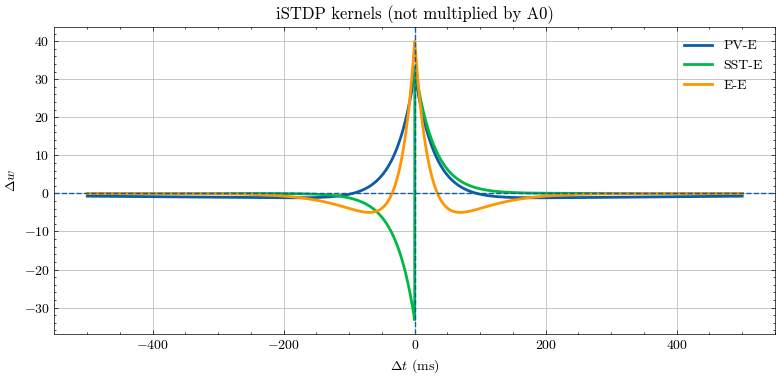

In [16]:
tau_plus_p = tauplus_stdp_p   
tau_minus_p = tauminus_stdp_p
tau_plus_s = tauplus_stdp_s        
tau_minus_s = tauminus_stdp_s

print(f"tau_plus_p: {tau_plus_p}; tau_minus_p: {tau_minus_p}; tau_plus_s: {tau_plus_s}; tau_minus_s: {tau_minus_s}")

def kernel_pv(dt_ms):
    return 1.0 * (Aplus_p * np.exp(-np.abs(dt_ms) / tau_plus_p)
                        + Aminus_p * np.exp(-np.abs(dt_ms) / tau_minus_p))

def kernel_sst(dt_ms):
    pos_lst = [dt_ms > 0, dt_ms < 0]
    out_lst = []
    for pos in pos_lst: 
        out = np.zeros_like(dt_ms, dtype=float)
        pos = dt_ms > 0
        neg = ~pos
        out[pos] = 1.0 * (Aplus_s  * np.exp(-dt_ms[pos] / tau_plus_s))
        out[neg] = 1.0 * (Aminus_s * np.exp(+dt_ms[neg] / tau_minus_s))  
        out_lst.append(out)

    return np.mean(out_lst, axis=0)

def remove_near_zero(lst, eps=1e-8):
    return np.array([x for x in lst if abs(x) > eps])

# E-E part
tau_plus_ee  = int(tau_p * 1000)
tau_minus_ee = int(tau_d * 1000)
print(f"tau_plus_ee: {tau_plus_ee}; tau_minus_ee: {tau_minus_ee}")
# A0learn_ee   = A0learn_e
A0learn_ee = 1.0
A_p_ee       = A_p * 1E3
A_d_ee       = A_d * 1E3

def kernel_ee(dt_ms):
    return A0learn_ee * (
        A_p_ee * np.exp(-np.abs(dt_ms) / tau_plus_ee) +
        A_d_ee * np.exp(-np.abs(dt_ms) / tau_minus_ee)
    )

dt_ms_test = np.linspace(-10000, 10000, 1000001)
dt_ms_show = np.linspace(-500, 500, 10001)

kpv_test = kernel_pv(dt_ms_test)
ksst_test = kernel_sst(remove_near_zero(dt_ms_test))
k_ee_test = kernel_ee(dt_ms_test)

kpv  = kernel_pv(dt_ms_show)
ksst = kernel_sst(remove_near_zero(dt_ms_show))
k_ee  = kernel_ee(dt_ms_show)

# half area should be positive and half negative and roughly match in magnitude
I_pv  = np.trapz(kernel_pv(dt_ms_test), dt_ms_test)
I_sst = np.trapz(kernel_sst(dt_ms_test), dt_ms_test)
I_ee  = np.trapz(kernel_ee(dt_ms_test), dt_ms_test)
print(f"I_pv: {I_pv:2f}; I_sst: {I_sst:2f}; I_ee: {I_ee:2f}")

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(dt_ms_show, kpv,  lw=2, label='PV-E')
ax.plot(remove_near_zero(dt_ms_show), ksst, lw=2, label='SST-E')
ax.plot(dt_ms_show, k_ee, lw=2, label='E-E')
ax.axhline(0, ls='--', lw=1)
ax.axvline(0, ls='--',  lw=1)
ax.set_xlabel(r'$\Delta t$ (ms)')
ax.set_ylabel(r'$\Delta w$')
ax.set_title('iSTDP kernels (not multiplied by A0)')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig(f'../Figures/torus_istdp_kernels_seed{tseed}.png', bbox_inches='tight', dpi=300)

In [17]:
# ###########################################
# Run warmup (no plasticity, no recording)
# ###########################################
print('== Running warmup ==')
run(time_warmup*second)
print('== Warmup done, now running with plasticity ==')

# ###########################################
# Run with spiketime recorder
# ###########################################
A0_e, A0_p, A0_s, A0_ep, A0_es = 0.0, 0.0, 0.0, 0.0, 0.0 # turn off plasticity

PIe_EE_period.active = True # not patch, just poisson input on E, while keep I input as well

spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = True, True, True
print('== Spike monitors activated ==')
run(time_checkspikes*second, report='text', report_period=60.0*second)
print(f'== Spike monitors deactivated ==')
spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = False, False, False

PIe_EE_period.active = False 

# ###########################################
# EE RUN
# ###########################################
A0_e, A0_p, A0_s, A0_ep, A0_es = A0learn_e, A0learn_p, A0learn_s, 0.0, 0.0 # turn on plasticity for the excitatory population
# A0_e, A0_p, A0_s, A0_ep, A0_es = A0learn_e, A0learn_p, A0learn_s, A0learn_ep, A0learn_es # turn on plasticity for the excitatory and inhibitory populations

spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = False, False, False
# Aug 9th: also try to record the population monitor in the phase of E-E plasticity
pop_re_mon.active, pop_rp_mon.active, pop_rs_mon.active = True, True, True

# adjust input (with patch input, never activate the Poisson input for EE)
PIe_EE_period.active, PIe_IE_period.active = False, False

# record the weights (that being shaped by plasticity during this phase)
mon_w_ee_EE.active, mon_w_pe_IE.active, mon_w_se_IE.active = True, True, True
mon_w_ep_EI.active, mon_w_es_EI.active = True, True

sp_in.active = True
# turn off the Poisson inputs for the inhibitory populations
PIp.active, PIs.active = False, False

print('== Running EE run with plasticity ==')
run(time_eerun*second, report='text', report_period=60.0*second)
print('== EE run complete == ')

pop_re_mon.active, pop_rp_mon.active, pop_rs_mon.active = False, False, False
mon_w_ee_EE.active, mon_w_pe_IE.active, mon_w_se_IE.active = False, False, False
mon_w_ep_EI.active, mon_w_es_EI.active = False, False

patch_spike1 = sp_in.num_spikes
print(f'Patch Input Generated Spikes in EE run: {patch_spike1}')
sp_in.active = False

# ###########################################
# Run with spiketime recorder
# still keep the patch input active
# ###########################################
A0_e, A0_p, A0_s, A0_ep, A0_es = 0.0, 0.0, 0.0, 0.0, 0.0 # turn off plasticity

Ge_EE_patch.active = False
Ie_EE_patch.active = False
PIe_EE_period.active, PIp.active, PIs.active = True, True, True

spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = True, True, True
print('== Spike monitors activated ==')
run(time_checkspikes*second, report='text', report_period=60.0*second)
print(f'== Spike monitors deactivated ==')
spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = False, False, False

PIe_EE_period.active, PIp.active, PIs.active = False, False, False

# ###########################################
# IE RUN
# ###########################################

# turn on the Poisson inputs for the inhibitory populations
# after spike recording? 
PIp.active, PIs.active = True, True 

# turn off the patch input
Ge_EE_patch.active = False
Ie_EE_patch.active = False

A0_e, A0_p, A0_s, A0_ep, A0_es = A0learn_e, 0.0, 0.0, A0learn_ep, A0learn_es # turn on plasticity for the inhibitory populations
# A0_e, A0_p, A0_s, A0_ep, A0_es = A0learn_e, A0learn_p, A0learn_s, A0learn_ep, A0learn_es # turn on plasticity for the excitatory and inhibitory populations

pop_re_mon.active, pop_rp_mon.active, pop_rs_mon.active = True, True, True

# turn on the Poisson input for the excitatory population during the IE run
PIe_EE_period.active, PIe_IE_period.active = False, True

# sanity check of the input
sp_in.active = False

# record the weights (that being shaped by plasticity during this phase)
mon_w_ee_EE.active, mon_w_pe_IE.active, mon_w_se_IE.active = True, True, True
mon_w_ep_EI.active, mon_w_es_EI.active = True, True

print('== Running IE run with plasticity ==')
run(time_training*second, report='text',report_period=60.0*second)
print('== IE Run Complete ==')

print("Patch Input Generated Spikes in EI run:", sp_in.num_spikes - patch_spike1) # this should be 0
sp_in.active = False

pop_re_mon.active, pop_rp_mon.active, pop_rs_mon.active = False, False, False

mon_w_ee_EE.active, mon_w_pe_IE.active, mon_w_se_IE.active = False, False, False
mon_w_ep_EI.active, mon_w_es_EI.active = False, False

# ###########################################
# Run with spiketime recorder
# ###########################################
A0_e, A0_p, A0_s, A0_ep, A0_es = 0.0, 0.0, 0.0, 0.0, 0.0 # turn off plasticity

spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = True, True, True
print('== Spike monitors activated ==')
run(time_checkspikes*second, report='text', report_period=60.0*second)
print(f'== Spike monitors deactivated ==')
spk_e_mon.active, spk_p_mon.active, spk_s_mon.active = False, False, False

print('******* \nRuns completed, preparing objects to save\n*******')

== Running warmup ==


WARNING    'i' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value 66303. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


== Warmup done, now running with plasticity ==
== Spike monitors activated ==
Starting simulation at t=3. s for a duration of 60. s
9.1229 s (15%) simulated in 1m 0s, estimated 5m 35s remaining.
18.367 s (30%) simulated in 2m 0s, estimated 4m 32s remaining.
27.5151 s (45%) simulated in 3m 0s, estimated 3m 33s remaining.
36.6629 s (61%) simulated in 4m 0s, estimated 2m 33s remaining.
45.6499 s (76%) simulated in 5m 0s, estimated 1m 34s remaining.
54.8695 s (91%) simulated in 6m 0s, estimated 34s remaining.
60. s (100%) simulated in 6m 35s
== Spike monitors deactivated ==
== Running EE run with plasticity ==
Starting simulation at t=63. s for a duration of 120. s
24.6135 s (20%) simulated in 1m 0s, estimated 3m 53s remaining.
63.242 s (52%) simulated in 2m 0s, estimated 1m 48s remaining.
114.5346 s (95%) simulated in 3m 0s, estimated 9s remaining.
120. s (100%) simulated in 3m 6s
== EE run complete == 
Patch Input Generated Spikes in EE run: 15600000
== Spike monitors activated ==
Starti

In [18]:
def fill_like(vec,val):
    n= len(vec)
    return np.full(n,val)
    
w_e2e_components = {
    'NE' : NE,
    'con_ee_ijw': np.stack(
            (np.array(con_ee.i),np.array(con_ee.j),np.array(con_ee.w)),axis=-1),
}
w_e2p_components = {
    'NE' : NE,
    'NP':NP,
    'con_ep_ijw': np.stack(
        (np.array(con_ep.i),np.array(con_ep.j),np.array(con_ep.w)),axis=-1),
}
w_p2e_components = {
    'NP':NP,
    'NE':NE,
    'con_pe_ijw': np.stack(
        (np.array(con_pe.i),np.array(con_pe.j),con_pe.w),axis=-1),
    }
w_p2p_components = {
    'NP':NP,
    'con_pp_ijw': np.stack(
            (np.array(con_pp.i),np.array(con_pp.j),fill_like(con_pp.i,w_pp)),axis=-1),
}

w_e2s_components = {
    'NE' : NE,
    'NS':NS,
    'con_es_ijw': np.stack(
        (np.array(con_es.i),np.array(con_es.j),np.array(con_es.w)),axis=-1),
    }
w_s2e_components = {
    'NS':NS,
    'NE':NE,
    'con_se_ijw': np.stack(
        (np.array(con_se.i),np.array(con_se.j),con_se.w),axis=-1),
    }
w_s2s_components = {
    'NS':NS,
    'con_ss_ijw': np.stack(
        (np.array(con_ss.i),np.array(con_ss.j),fill_like(con_ss.i,w_ss)),axis=-1),
    }
w_p2s_components = {
    'NP':NP,
    'NS':NS,
    'con_ps_ijw': np.stack(
        (np.array(con_ps.i),np.array(con_ps.j),fill_like(con_ps.i,w_ps)),axis=-1),
}
w_s2p_components = {
    'NS':NS,
    'NP':NP,
    'con_sp_ijw': np.stack(
        (np.array(con_sp.i),np.array(con_sp.j),fill_like(con_sp.i,w_sp)),axis=-1),
}

# Export population rates
pop_re_times = pop_re_mon.t / second
pop_re_rates = pop_re_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rp_times = pop_rp_mon.t / second
pop_rp_rates = pop_rp_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rs_times = pop_rs_mon.t / second
pop_rs_rates = pop_rs_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
    
print('Now saving data on file')

Now saving data on file


In [19]:
save_dict = { 
        'ne':NE,
        'np':NP,
        'ns':NS,
        'w_e2e_components':w_e2e_components,
        'w_e2p_components':w_e2p_components,
        'w_e2s_components':w_e2s_components,
        'w_p2e_components':w_p2e_components,
        'w_s2e_components':w_s2e_components,
        'w_p2s_components':w_p2s_components,
        'w_s2p_components':w_s2p_components,
        'w_p2p_components':w_p2p_components,
        'w_s2s_components':w_s2s_components,
        'pop_re_times':pop_re_times,
        'pop_re_rates':pop_re_rates,
        'pop_rp_times':pop_rp_times,
        'pop_rp_rates':pop_rp_rates,
        'pop_rs_times':pop_rs_times,
        'pop_rs_rates':pop_rs_rates,
        'spikeindices_e':np.array(spk_e_mon.i),
        'spiketimes_e':np.array(spk_e_mon.t/second),
        'spikeindices_p':np.array(spk_p_mon.i),
        'spiketimes_p':np.array(spk_p_mon.t/second),
        'spikeindices_s':np.array(spk_s_mon.i),
        'spiketimes_s':np.array(spk_s_mon.t/second),
        }

savetemppath = f'brian2network_{save_id}_seed{tseed}.pkl'

print('******* \n Run completed!\n*******')

******* 
 Run completed!
*******


In [20]:
def recorded_mapping(syn, rec_spec):
    """
    """
    if rec_spec is True:
        ridx = np.arange(syn.N, dtype=np.int64)
    else:
        ridx = np.array(rec_spec, dtype=np.int64)
    pre  = np.array(syn.i, dtype=np.int32)[ridx]
    post = np.array(syn.j, dtype=np.int32)[ridx]
    return {'syn_idx': ridx, 'pre': pre, 'post': post}

ee_map = recorded_mapping(con_ee, rec_ee)
pe_map = recorded_mapping(con_pe, rec_pe)
se_map = recorded_mapping(con_se, rec_se)
ep_map = recorded_mapping(con_ep, rec_ep)
es_map = recorded_mapping(con_es, rec_es)

ee_times = np.array(mon_w_ee_EE.t/second)
pe_times = np.array(mon_w_pe_IE.t/second)
se_times = np.array(mon_w_se_IE.t/second)
ep_times = np.array(mon_w_ep_EI.t/second)
es_times = np.array(mon_w_es_EI.t/second)

ee_w_traj = np.array(mon_w_ee_EE.w, dtype=np.float32)  
pe_w_traj = np.array(mon_w_pe_IE.w, dtype=np.float32)  
se_w_traj = np.array(mon_w_se_IE.w, dtype=np.float32)  
ep_w_traj = np.array(mon_w_ep_EI.w, dtype=np.float32)
es_w_traj = np.array(mon_w_es_EI.w, dtype=np.float32)

save_dict.update({
    'weight_sampling_dt_s': float(sample_every/second),

    'EE_weight_times_s': ee_times,
    'EE_weight_traj':    ee_w_traj,  
    'EE_weight_map':     ee_map,

    'PE_weight_times_s': pe_times,
    'PE_weight_traj':    pe_w_traj,
    'PE_weight_map':     pe_map,

    'SE_weight_times_s': se_times,
    'SE_weight_traj':    se_w_traj,
    'SE_weight_map':     se_map,
})

save_dict.update({
    'EP_weight_times_s': ep_times,
    'EP_weight_traj':    ep_w_traj,
    'EP_weight_map':     ep_map,

    'ES_weight_times_s': es_times,
    'ES_weight_traj':    es_w_traj,
    'ES_weight_map':     es_map,
})

In [21]:
# record_num = ee_w_traj.shape[1]
# figetraj, axsetraj = plt.subplots(1, record_num, figsize=(4*record_num, 4))
# for record_index in range(record_num):
#     w_ee_full_traj = np.zeros((NE, NE))
#     pre = ee_map['pre']
#     post = ee_map['post']
#     for (i,j,w) in zip(pre, post, ee_w_traj[:,record_index]):
#         w_ee_full_traj[j,i] = w
#     sns.heatmap(w_ee_full_traj, ax=axsetraj[record_index], cmap='coolwarm', cbar=True)
# figetraj.tight_layout()

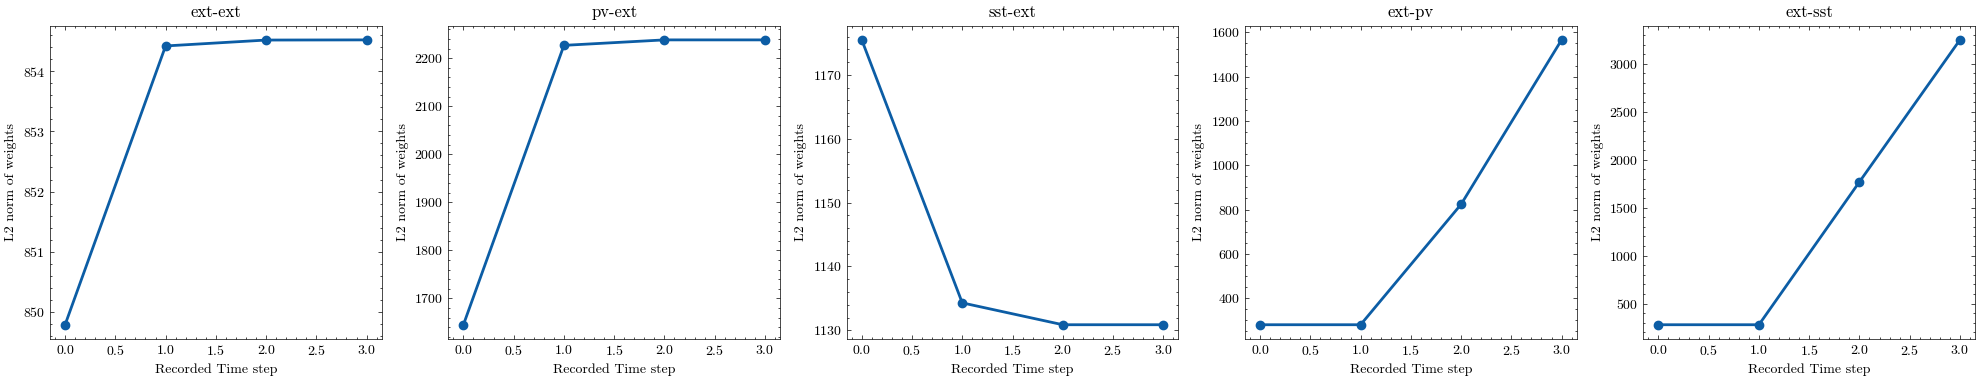

In [22]:

figtrajweight, axstrajweight = plt.subplots(1,5,figsize=(4*5,4))
alltraj = [[ee_w_traj, "ext-ext"], [pe_w_traj, "pv-ext"], [se_w_traj, "sst-ext"], [ep_w_traj, "ext-pv"], [es_w_traj, "ext-sst"]]
for (index, (traj, label)) in enumerate(alltraj):
    frob_norm = [np.linalg.norm(traj[:,i]) for i in range(traj.shape[1])]
    axstrajweight[index].plot(frob_norm, "-o", linewidth=2)
    axstrajweight[index].set_ylabel('L2 norm of weights')
    axstrajweight[index].set_xlabel('Recorded Time step')
    axstrajweight[index].set_title(label)
figtrajweight.tight_layout()
figtrajweight.savefig(f'../Figures/weight_change_during_learning_seed{tseed}.png', bbox_inches='tight', dpi=300)

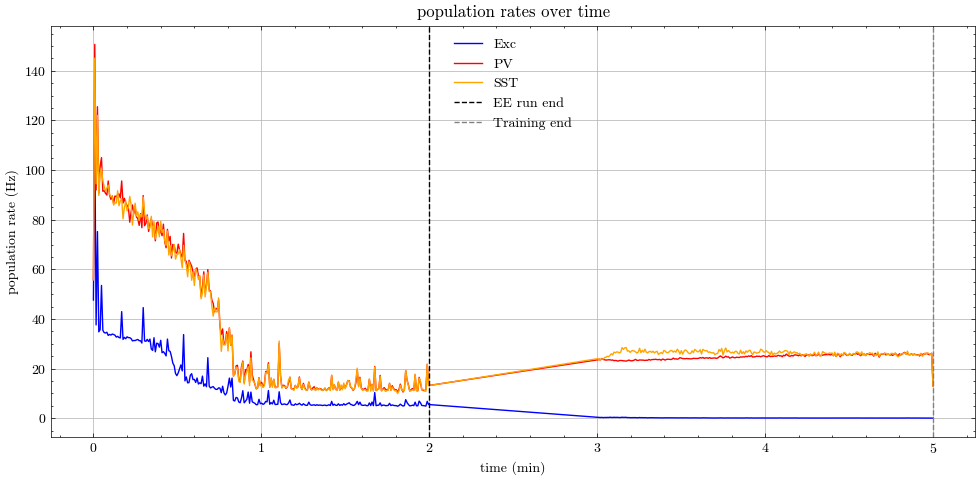

In [23]:
nplot = 500
time_end = time_eerun + time_training + time_checkspikes
# end this before the spike recording starts
pop_re_times_aligned = pop_re_times - (time_warmup + time_checkspikes)
# idx_end = np.argmax(pop_re_times_aligned>time_end)
idx_end = len(pop_re_times_aligned) - 1
ee_end = time_eerun / 60 
ie_end = (time_eerun + time_checkspikes + time_training) / 60

idxplot = np.linspace(start=1,stop=idx_end,num=nplot).round().astype(int) # subsample, as data points are too many
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(pop_re_times_aligned[idxplot]/60, pop_re_rates[idxplot], label='Exc',color="blue")
ax.plot(pop_re_times_aligned[idxplot]/60, pop_rp_rates[idxplot], label='PV', color="red")
ax.plot(pop_re_times_aligned[idxplot]/60, pop_rs_rates[idxplot], label='SST', color="orange")
ax.axvline(ee_end, ls='--', color='black', label='EE run end')
ax.axvline(ie_end, ls='--', color='gray', label='Training end')

ax.set_xlabel('time (min)')
ax.set_ylabel('population rate (Hz)')
ax.set_title('population rates over time')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig(f"../Figures/torus_two_interneurons_pop_rates_seed{tseed}.png", bbox_inches='tight', dpi=300)

In [24]:
def unband_and_center(mat, indexes=None):
    nrow, ncol = mat.shape
    if indexes is None:  # only works on square matrices
        indexes = np.arange(ncol)
    assert len(indexes) == nrow, "indexes must have same length as rows of mat"
    assert np.all((0 <= indexes) & (indexes <= ncol-1)), "indexes must be in the range 0:ncol-1"
    inddiff = np.diff(indexes)
    if np.any(inddiff > 1):
        raise ValueError("indexes are not contiguous")
    ret = np.empty((nrow, ncol), dtype=mat.dtype)
    ncenter = ncol // 2 - 1
    for i in range(nrow):
        for j in range(ncol):
            js = (j + indexes[i] ) % ncol
            ret[i, (j + ncenter) % ncol] = mat[i, js]
    return ret

def mean_and_norm(mat):
    ret = np.mean(mat, axis=0)
    ret /= np.max(ret)
    return ret

def mean_cols_nodiagonal(mat):
    nrows, ncols = mat.shape
    ret = np.empty(ncols, dtype=mat.dtype)
    for j in range(ncols):
        ret[j] = np.sum(np.delete(mat[:, j], j))
    ret /= (nrows - 1)
    return ret

def unband_mean_normalize(mat, indexes=None):
    if indexes is None:
        indexes = np.arange(1, mat.shape[1] + 1)
    mat_unband = unband_and_center(mat, indexes)
    means = mean_cols_nodiagonal(mat_unband)
    return means / np.max(means)

In [25]:
w_ee_full = np.zeros((NE,NE),dtype=float)
for (i,j,w) in zip(con_ee.i,con_ee.j,con_ee.w):
    w_ee_full[j,i] = w
w_es_full = np.zeros((NS,NE),dtype=float)
for (i,j,w) in zip(con_es.i,con_es.j,con_es.w):
    w_es_full[j,i] = w
w_se_full = np.zeros((NE,NS),dtype=float)
for (i,j,w) in zip(con_se.i,con_se.j,con_se.w):
    w_se_full[j,i] = w
w_ep_full = np.zeros((NP,NE),dtype=float)
for (i,j,w) in zip(con_ep.i,con_ep.j,con_ep.w):
    w_ep_full[j,i] = w
w_pe_full = np.zeros((NE,NP),dtype=float)
for (i,j,w) in zip(con_pe.i,con_pe.j,con_pe.w):
    w_pe_full[j,i] = w
    
w_ps_full = np.zeros((NS,NP),dtype=float)
for (i,j) in zip(con_ps.i,con_ps.j):
    w_ps_full[j,i] = w_ps
w_sp_full = np.zeros((NP,NS),dtype=float)
for (i,j) in zip(con_sp.i,con_sp.j):
    w_sp_full[j,i] = w_sp
w_pp_full = np.zeros((NP,NP),dtype=float)
for (i,j) in zip(con_pp.i,con_pp.j):
    w_pp_full[j,i] = w_pp
w_ss_full = np.zeros((NS,NS),dtype=float)
for (i,j) in zip(con_ss.i,con_ss.j):
    w_ss_full[j,i] = w_ss

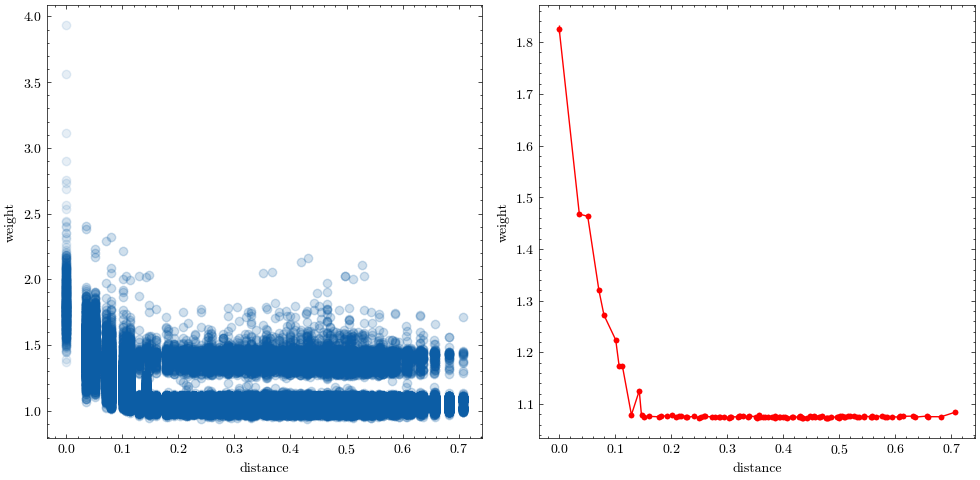

In [26]:
def mean_by_key(R, W, mask=None, decimals=None):
    """
    Groups W by identical values in R and returns a list of
    (key, mean, nstd), where nstd is the standard error of the mean.
    """
    if mask is None:
        mask = np.ones_like(R, dtype=bool)
    Rm = R[mask].ravel()
    Wm = W[mask].ravel()
    if decimals is not None:
        Rm = np.round(Rm, decimals)

    keys, inv = np.unique(Rm, return_inverse=True)
    counts = np.bincount(inv)
    sum_w  = np.bincount(inv, weights=Wm)
    sum_w2 = np.bincount(inv, weights=Wm * Wm)

    means = sum_w / counts

    ssd   = sum_w2 - (sum_w ** 2) / counts
    denom = np.maximum(counts - 1, 1)
    var   = ssd / denom
    var[counts == 1] = 0.0
    std   = np.sqrt(np.maximum(var, 0.0))

    nstd = std / np.sqrt(counts)  # SEM

    return list(zip(keys.tolist(), means.tolist(), nstd.tolist()))

mask = w_ee_full > 0
key_mean = np.array(mean_by_key(R_ee, w_ee_full, mask=mask, decimals=3))

fig, axs = plt.subplots(1,2,figsize=(5*2,5))
axs[0].scatter(R_ee.flatten(), w_ee_full.flatten(), alpha=0.1)
axs[1].plot(key_mean[:,0], key_mean[:,1], '-o', color='red', markersize=3)
axs[1].errorbar(key_mean[:,0], key_mean[:,1], yerr=key_mean[:,2], fmt='o', color='red', markersize=3)
for ax in axs:
    ax.set_xlabel('distance')
    ax.set_ylabel('weight')
fig.tight_layout()

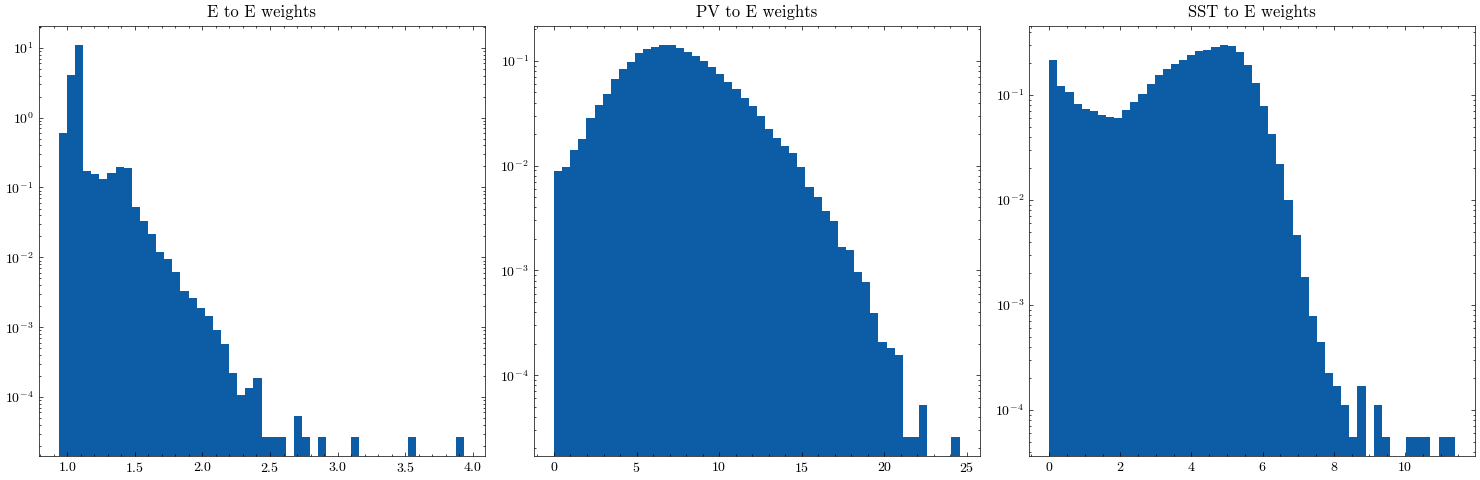

In [27]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(w_ee_full.flatten(), bins=50, density=True, log=True)
ax[1].hist(w_pe_full.flatten(), bins=50, density=True, log=True)
ax[2].hist(w_se_full.flatten(), bins=50, density=True, log=True)
ax[0].set_title('E to E weights')
ax[1].set_title('PV to E weights')
ax[2].set_title('SST to E weights')
fig.tight_layout()
fig.savefig(f"../Figures/torus_final_weights_hist_seed{tseed}.png", bbox_inches='tight', dpi=300)

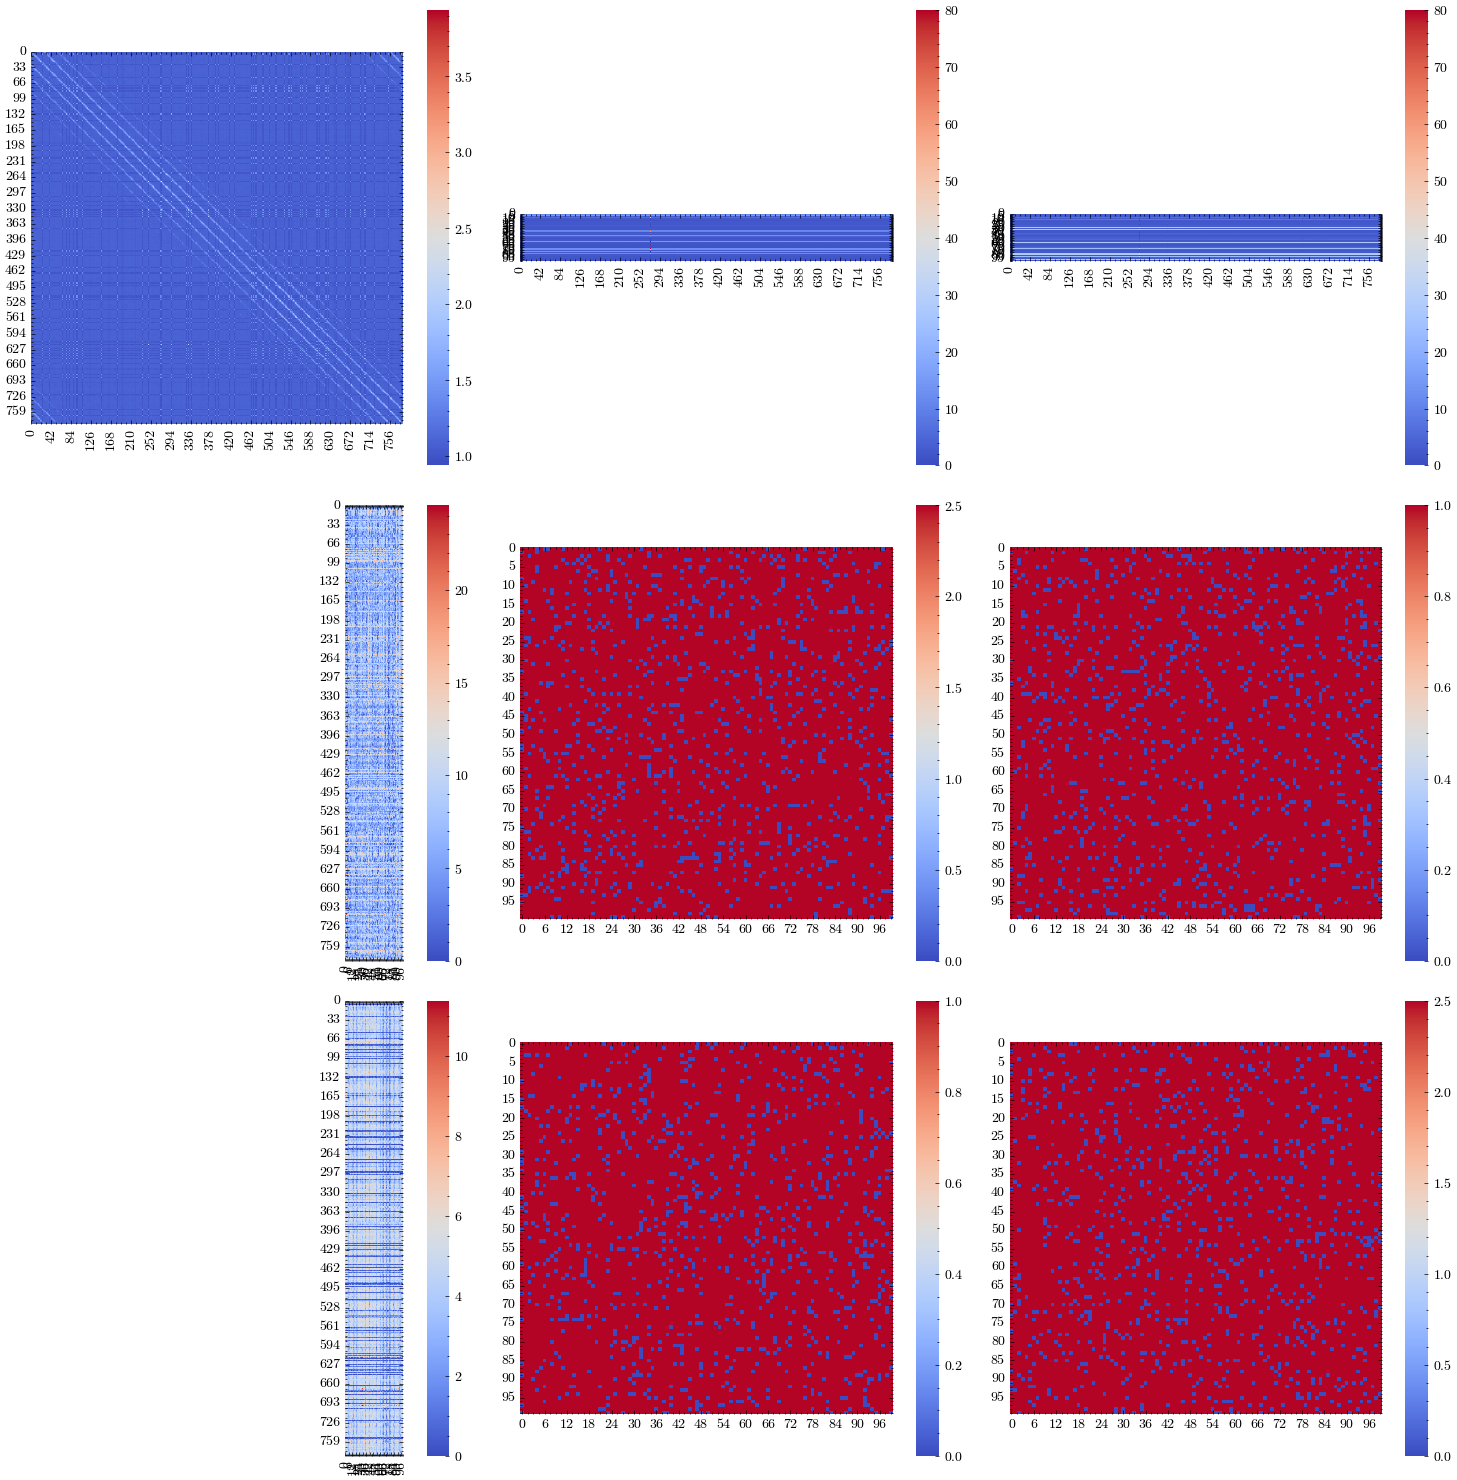

In [28]:
fig, ax = plt.subplots(3,3,figsize=(5*3,5*3))
sns.heatmap(w_ee_full, ax=ax[0,0], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_ep_full, ax=ax[0,1], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_es_full, ax=ax[0,2], cmap='coolwarm', cbar=True, square=True)

sns.heatmap(w_pe_full, ax=ax[1,0], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_pp_full, ax=ax[1,1], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_ps_full, ax=ax[1,2], cmap='coolwarm', cbar=True, square=True)

sns.heatmap(w_se_full, ax=ax[2,0], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_sp_full, ax=ax[2,1], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(w_ss_full, ax=ax[2,2], cmap='coolwarm', cbar=True, square=True)
fig.tight_layout()
fig.savefig(f"../Figures/torus_final_weights_seed{tseed}.png", bbox_inches='tight', dpi=300)

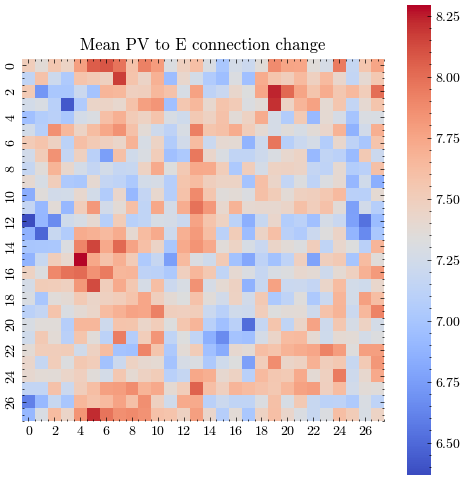

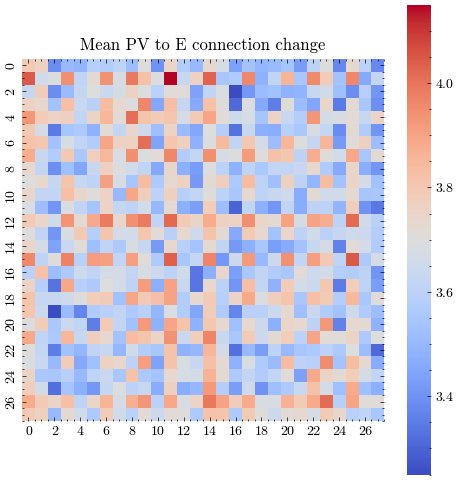

In [29]:
import math 

side_NE, side_NP, side_NS = int(math.sqrt(NE)), int(math.sqrt(NP)), int(math.sqrt(NS))
center_NP, center_NS = [side_NP // 2, side_NP // 2], [side_NS // 2, side_NS // 2]
grid_NE, grid_NP, grid_NS = 1 / side_NE, 1 / side_NP, 1 / side_NS

connection_pack = [[side_NP, center_NP, grid_NP, w_pe_full, "PV"],
                   [side_NS, center_NS, grid_NS, w_se_full, "SST"]]

for (side_Ninh, center_Ninh, grid_Ninh, w_inhe_full, inh_name) in connection_pack:
    one_inh_to_e_change_all = []
    for neuron_inh in range(w_inhe_full.shape[1]):    
        one_inh_to_e = w_inhe_full[:, neuron_inh].reshape((side_NE, side_NE))
        inh_loc_index = [neuron_inh // side_Ninh, neuron_inh % side_Ninh]
        move_index = [center_Ninh[0] - inh_loc_index[0], center_Ninh[1] - inh_loc_index[1]]
        move_p_dim = [round(move_index[0] * grid_Ninh / grid_NE), round(move_index[1] * grid_Ninh / grid_NE)]
        one_inh_to_e_change = np.roll(one_inh_to_e, move_p_dim, axis=(0, 1))
        one_inh_to_e_change_all.append(one_inh_to_e_change)

    one_inh_to_e_change_all = np.array(one_inh_to_e_change_all)
    mean_one_pv_to_e_change = np.mean(one_inh_to_e_change_all, axis=0)

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    sns.heatmap(mean_one_pv_to_e_change, ax=ax, cmap='coolwarm', cbar=True, square=True)
    ax.set_title('Mean PV to E connection change')
    fig.tight_layout()
    fig.savefig(f"../Figures/torus_mean_{inh_name}_to_e_rawconn_seed{tseed}.png", bbox_inches='tight', dpi=300)    


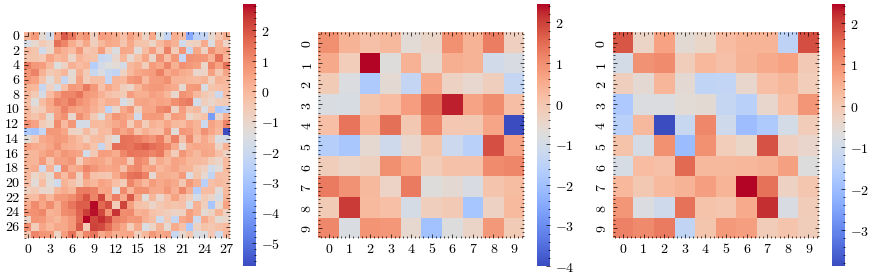

In [30]:
# calculate the effective weight matrix
NTOT=NE+NP+NS
idx_e = np.arange(NE)
idx_p = NE+np.arange(NP)
idx_s = NE+NP+np.arange(NS)

w_full = np.zeros((NTOT,NTOT),dtype=float)
w_full[np.ix_(idx_e,idx_e)]=w_ee_full
w_full[np.ix_(idx_p,idx_e)]=w_ep_full
w_full[np.ix_(idx_e,idx_p)]=-w_pe_full
w_full[np.ix_(idx_p,idx_p)]=-w_pp_full

w_full[np.ix_(idx_s,idx_e)]=w_es_full
w_full[np.ix_(idx_e,idx_s)]=-w_se_full
w_full[np.ix_(idx_s,idx_s)]=-w_ss_full

w_full[np.ix_(idx_s,idx_p)]=-w_ps_full
w_full[np.ix_(idx_p,idx_s)]=-w_sp_full

# Just the sum of powers of the weight matrix
w_effective = (np.eye(NTOT) 
              + w_full 
               + w_full @ w_full 
               + w_full @ w_full @ w_full 
               + w_full @ w_full @ w_full @ w_full
               + w_full @ w_full @ w_full @ w_full  @ w_full  
               + w_full @ w_full @ w_full @ w_full  @ w_full @ w_full
)

dict_info = [[idx_e, "excitatory"], [idx_p, "PV"], [idx_s, "SST"]]

fig, ax = plt.subplots(1,3,figsize=(3*3,3))

for index, (idx, label) in enumerate(dict_info):
    w_effective_ee = w_effective[np.ix_(idx, idx)]
    profile_ee_effective=mean_and_norm(unband_and_center(w_effective_ee))
    profile_ee_effective_zscored = (profile_ee_effective - profile_ee_effective.mean()) / profile_ee_effective.std()
    reshape_ = int(math.sqrt(profile_ee_effective_zscored.shape[0]))

    sns.heatmap(profile_ee_effective_zscored.reshape((reshape_, reshape_)), ax=ax[index], cmap='coolwarm', \
        cbar=True, square=True)

fig.tight_layout()
fig.savefig(f"../Figures/torus_two_interneurons_effective_profile_seed{tseed}.png", bbox_inches='tight', dpi=300)

In [31]:
def participation_ratio(C, normalize=False, eps=1e-12):
    C = np.array(C, float)
    C = 0.5*(C + C.T)
    trC  = np.trace(C)
    fro2 = np.sum(C*C)               # = tr(C^2) for symmetric C
    if fro2 <= eps: 
        return np.nan
    PR = (trC*trC)/fro2              # in [1,N] for PSD; scale-invariant
    return PR/C.shape[0] if normalize else PR

In [32]:
from matplotlib.animation import FuncAnimation, PillowWriter

def make_square_heatmap_movie(
    X,
    out_path="heatmap.gif",
    fps=5,
    scale="global",          # "global", "perframe", or (vmin, vmax)
    order="NT",
    origin="lower",
    add_colorbar=True,
    symmetric=True,          # make limits symmetric around 0 (recommended for coolwarm)
    robust=True,             # use percentiles to ignore outliers
    p_low=1.0,               # low percentile for robust scaling
    p_high=99.0,             # high percentile for robust scaling
    cbar_label=None
):
    """
    Create a heatmap movie from an N×T array where each column is a frame.
    Adds a fixed colorbar with robust, symmetric global limits by default.
    """
    if order == "TN":
        X = X.T
    N, T = X.shape
    s = int(np.sqrt(N))
    if s * s != N:
        raise ValueError(f"N={N} is not a perfect square.")

    # Determine fixed color limits
    if isinstance(scale, tuple) and len(scale) == 2:
        vmin, vmax = scale
    else:
        if scale == "perframe":
            # Fixed colorbar requested -> override to global limits
            print("Note: 'perframe' scale overridden to fixed global limits to keep colorbar fixed.")
        finite = np.isfinite(X)
        if not np.any(finite):
            vmin, vmax = -1.0, 1.0
        else:
            data = X[finite]
            if robust:
                lo = np.nanpercentile(data, p_low)
                hi = np.nanpercentile(data, p_high)
            else:
                lo, hi = np.nanmin(data), np.nanmax(data)
            if symmetric:
                m = max(abs(lo), abs(hi))
                vmin, vmax = -m, m
            else:
                vmin, vmax = lo, hi

    # Safety: avoid identical limits
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = -1.0, 1.0
    if vmin == vmax:
        eps = 1e-12 if vmin == 0 else 1e-6 * abs(vmin)
        vmin, vmax = vmin - eps, vmax + eps

    # since we are plotting on firing rate, it will be non-negative
    first = np.reshape(X[:, 0], (s, s))
    fig, ax = plt.subplots()
    im = ax.imshow(first, vmin=0.0, vmax=vmax, interpolation="nearest",
                   origin=origin, cmap="coolwarm")
    ax.set_xticks([])
    ax.set_yticks([])
    ttl = ax.set_title("t = 0")

    # Fixed colorbar
    if add_colorbar:
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        if cbar_label is not None:
            cbar.set_label(cbar_label)

    fig.tight_layout()

    def update(t):
        frame = np.reshape(X[:, t], (s, s))
        # Keep fixed colorbar: do NOT change limits per frame
        im.set_data(frame)
        ttl.set_text(f"t = {t}")
        return (im, ttl)

    anim = FuncAnimation(fig, update, frames=T, interval=1000 / fps, blit=True)

    path = out_path
    try:
        if out_path.lower().endswith(".gif"):
            anim.save(out_path, writer=PillowWriter(fps=fps), dpi=300)
        else:
            from matplotlib.animation import FFMpegWriter
            anim.save(out_path, writer=FFMpegWriter(fps=fps), dpi=300)
    except Exception as e:
        # Fallback to GIF if MP4 fails
        print(e)
        path = out_path.rsplit(".", 1)[0] + ".gif"
        anim.save(path, writer=PillowWriter(fps=fps), dpi=300)
    plt.close(fig)
    return path


In [33]:
# bin_width = 500.0 * 0.001 # in ms
# t_start = 0
# t_stop  = time_checkspikes                    
# bins    = np.arange(t_start, t_stop + bin_width, bin_width)
# t_axis = (bins[:-1] + bin_width/2)

# # fig, ax = plt.subplots(3,1,figsize=(20,4*3))
# figcorr, axcorr = plt.subplots(3,3,figsize=(4*3,4*3))
# figpr, axpr = plt.subplots(1,1,figsize=(4,4))

# dict_info = [[NE, spk_e_mon, "excitatory"], [NP, spk_p_mon, "PV"], [NS, spk_s_mon, "SST"]]
# for index, (NUM, spk_mon, spk_name) in enumerate(dict_info):
#     neuron_collection = [[], [], []] 
#     for ne_index in range(NUM):
#         st = np.array(spk_mon.spike_trains()[ne_index] / second)
#         # in the current design of code, we will record spikes for 3 times (before learning, post-EE, and post-IE)
#         # for plotting purpose here, we only show the last record
#         t0 = time_warmup + time_eerun + time_training + 2 * time_checkspikes
#         # t0 = time_warmup
#         # t0 = time_warmup + time_checkspikes + time_eerun
#         m = (st >= t0) & (st < t0 + time_checkspikes)
#         spike_aligned = st[m] - t0
#         counts, _ = np.histogram(spike_aligned, bins=bins)
#         rate_hz   = counts / bin_width
#         # record the firing rate information for movie generation
#         # log less frequently
#         if ne_index % 100 == 0:
#             print(f"{index}; neuron {ne_index} mean rate: {np.mean(rate_hz):.2f} Hz; shape: {rate_hz.shape}")
#         # ax[index].plot(t_axis, rate_hz, color="blue", alpha=0.1)
        
#         # find different spike recording period 
#         # before training; post EE training; post IE training
#         t0s = [time_warmup, time_warmup + time_checkspikes + time_eerun, time_warmup + time_eerun + time_training + 2 * time_checkspikes]
#         assert len(neuron_collection) == len(t0s) 
#         for (t0_index, t0_) in enumerate(t0s):
#             m = (st >= t0_) & (st < t0_ + time_checkspikes)
#             spike_aligned_ = st[m] - t0_
#             counts, _ = np.histogram(spike_aligned_, bins=bins)
#             rate_hz   = counts / bin_width
#             neuron_collection[t0_index].append(rate_hz)  

#     # ax[index].set_xlabel('Time (s)')
#     # ax[index].set_ylabel('Spike rate (Hz)')
#     # ax[index].set_title(f'Spike rate of {spk_name} neurons')
    
#     neuron_collection = [np.array(x) for x in neuron_collection]
#     neuron_corr = [np.corrcoef(x) for x in neuron_collection]
#     neuron_pr = [participation_ratio(c, normalize=True) for c in neuron_corr]
#     axpr.plot(neuron_pr, '-o', label=spk_name, markersize=3)
    
#     for (corrindex, corr) in enumerate(neuron_corr): 
#         sns.heatmap(corr, ax=axcorr[index, corrindex], cmap='coolwarm', cbar=True, square=True)
#         axcorr[index, corrindex].set_title(f'{spk_name} correlation matrix {corrindex}')

# # fig.tight_layout()
# # fig.savefig(f"../Figures/torus_two_interneurons_spikes_seed{tseed}.png", bbox_inches='tight', dpi=300)

# axpr.set_xlabel("Stage")
# axpr.set_ylabel("Normalized Participation Ratio")
# axpr.legend()
# figpr.tight_layout()
# figpr.savefig(f"../Figures/torus_two_interneurons_participation_ratio_seed{tseed}.png", bbox_inches='tight', dpi=300)

# figcorr.tight_layout()
# figcorr.savefig(f"../Figures/torus_two_interneurons_corr_seed{tseed}.png", bbox_inches='tight', dpi=1000)

In [34]:
def grid_shape_like_assign(n, Lx=1.0, Ly=1.0):
    """
    Match the (nx, ny) implied by assign_positions_2d(n, Lx, Ly).
    """
    nx = int(np.round(np.sqrt(n * Lx / Ly)))
    nx = max(nx, 1)
    ny = int(np.ceil(n / nx))
    return nx, ny

def bin_to_assign_grid(x, y, val, n, Lx=1.0, Ly=1.0):
    """
    Bin scattered (x,y,val) to the grid implied by assign_positions_2d(n, Lx, Ly),
    averaging values when multiple neurons land in the same cell.
    Returns a (ny, nx) array and (nx, ny) for plotting extents if needed.
    """
    nx, ny = grid_shape_like_assign(n, Lx, Ly)
    dx, dy = Lx / nx, Ly / ny

    ix = np.floor(x / dx).astype(int); ix = np.clip(ix, 0, nx-1)
    iy = np.floor(y / dy).astype(int); iy = np.clip(iy, 0, ny-1)

    Hsum = np.zeros((ny, nx), dtype=float)
    Hcnt = np.zeros((ny, nx), dtype=int)
    for ixx, iyy, v in zip(ix, iy, val):
        if np.isfinite(v):
            Hsum[iyy, ixx] += v
            Hcnt[iyy, ixx] += 1
    H = np.full((ny, nx), np.nan, dtype=float)
    m = Hcnt > 0
    H[m] = Hsum[m] / Hcnt[m]
    return H, nx, ny

def plot_seed_corr_maps_assign(pop_name, N, spk_mon, pos, Lx=1.0, Ly=1.0,
                               seeds_per_pop=6, bin_ms=200.0, rng_seed=0,
                               vlim=0.2):
    """
    Choose random seeds among active neurons of a population and show correlation
    to all neurons as a heatmap arranged on the grid implied by assign_positions_2d.
    """
    idx = np.array(spk_mon.i, dtype=np.int32)
    tt  = np.array(spk_mon.t/second, dtype=np.float64)
    if tt.size == 0:
        raise ValueError(f"No spikes recorded for {pop_name}.")
    # ending time
    t1 = float(tt[-1])
    print(f"t1: {t1:.2f} s")
    print(f"Expected Ending Time: {time_warmup + time_eerun + time_training + 3 * time_checkspikes:.2f} s")
    # last spike record period (after both EE and IE training)
    t0 = t1 - float(time_checkspikes)
    dt = bin_ms / 1000.0
    edges = np.arange(t0, t1 + dt, dt)
    nb = len(edges) - 1

    m = (tt >= t0) & (tt < t1)
    idx = idx[m]; tt = tt[m]

    counts = np.zeros((nb, N), dtype=np.float32)
    if len(tt) > 0:
        bidx = np.floor((tt - t0) / dt).astype(np.int64)
        np.add.at(counts, (bidx, idx), 1.0)

    spike_totals = counts.sum(axis=0)
    keep = spike_totals >= 1
    assert np.sum(keep) == counts.shape[1], "keep does not match counts"
    counts = counts[:, keep]
    kept_idx = np.where(keep)[0]
    if counts.shape[1] < 2:
        raise ValueError(f"Not enough active neurons in {pop_name} after filtering.")
    
    counts_movie = counts.T 
    print(f"Movie generation start for {pop_name} neurons")
    counts_movie = np.array(counts_movie)
    counts_movie = make_square_heatmap_movie(counts_movie, out_path=f"../Figures/torus_two_interneurons_spikes_{pop_name}_calcium_seed{tseed}.mp4")
    print(f"Movie generation done for {pop_name} neurons")
    
    mu = counts.mean(axis=0, keepdims=True)
    sd = counts.std(axis=0, ddof=1, keepdims=True)
    good = (sd[0] > 0)
    counts = counts[:, good]
    kept_idx = kept_idx[good]
    Z = (counts - mu[:, good]) / sd[:, good]
    T, M = Z.shape

    rng = np.random.default_rng(rng_seed)
    seed_cols = rng.choice(M, size=min(seeds_per_pop, M), replace=False)
    seed_cols_all = np.arange(M)

    fig, axs = plt.subplots(1, len(seed_cols), figsize=(4*len(seed_cols), 4), constrained_layout=True)
    if len(seed_cols) == 1:
        axs = [axs]

    H_all = []
    for _, sc in enumerate(seed_cols_all):
        cvec = (Z[:, sc].T @ Z) / (T - 1) 
        full_corr = np.full(N, np.nan, dtype=float)
        full_corr[kept_idx] = cvec

        H, _, _ = bin_to_assign_grid(pos[:,0], pos[:,1], full_corr, n=N, Lx=Lx, Ly=Ly)
        
        # calculate for all possible seeds, but only plot the selected ones
        if sc in seed_cols:
            k = np.where(seed_cols == sc)[0][0]
            ax = axs[k]
            im = ax.imshow(H, origin='lower', extent=[0, Lx, 0, Ly],
                        vmin=-vlim, vmax=+vlim, aspect='equal', cmap="coolwarm")

            seed_global = kept_idx[sc]
            ax.plot(pos[seed_global,0], pos[seed_global,1], marker='o', markersize=6, 
                    markeredgecolor='k', markerfacecolor='none')
            ax.set_title(f'{pop_name} seed {seed_global}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.grid(False)   
            
        N_root = int(math.sqrt(N))
        loc_index = [sc // N_root, sc % N_root]
        center_N = [int(N_root / 2), int(N_root / 2)]
        move_index = [center_N[0] - loc_index[0], center_N[1] - loc_index[1]]
        move_p_dim = [round(move_index[0]), round(move_index[1])]
        H_shift = np.roll(H, move_p_dim, axis=(0, 1))  
        H_all.append(H_shift)

    cbar = fig.colorbar(im, ax=axs, shrink=0.85)
    cbar.set_label('Pearson corr')
    fig.suptitle(f'{pop_name} seed correlation maps (bin={bin_ms:.0f} ms)', y=1.02)
    fig.savefig(f'../Figures/torus_two_interneurons_seed_corr_maps_{pop_name}_seed{tseed}.png',
                bbox_inches='tight', dpi=300)
    
    H_all = np.array(H_all)
    H_mean = np.mean(H_all, axis=0)   
    fig_mean, ax_mean = plt.subplots(1,1,figsize=(5,5))
    im_mean = ax_mean.imshow(H_mean, origin='lower', extent=[0, Lx, 0, Ly],
                   vmin=-vlim, vmax=+vlim, aspect='equal', cmap="coolwarm")
    ax_mean.set_title(f'{pop_name} mean seed correlation map')
    ax_mean.set_xlabel('x')
    ax_mean.set_ylabel('y')
    cbar = fig.colorbar(im_mean, ax=ax_mean, shrink=0.85)
    cbar.set_label('Pearson corr')
    fig_mean.savefig(f'../Figures/torus_two_interneurons_seed_corr_maps_mean_{pop_name}_seed{tseed}.png',
                bbox_inches='tight', dpi=300)
    
    hh = int(H_mean.shape[0] / 2)
    hhxx = np.linspace(0,1, H_mean.shape[0])
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(hhxx, H_mean[hh, :], label='horizontal', color='blue')
    ax.plot(hhxx, H_mean[:, hh], label='vertical', color='orange')
    ax.legend()
    ax.set_ylim([-0.2, 1.0])
    ax.axhline(0.0, ls='--', color='k', lw=1)
    ax.set_xlabel("Spatial position (normalized)")
    ax.set_ylabel("Mean correlation")
    fig.tight_layout()
    fig.savefig(f'../Figures/torus_two_interneurons_seed_corr_maps_mean_profile_{pop_name}_seed{tseed}.png',
                bbox_inches='tight', dpi=300)
    
bin_ms = 500.0
seeds_per_pop = 6

plot_seed_corr_maps_assign('E',   NE, spk_e_mon, pos_e, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=1, vlim=0.2)
plot_seed_corr_maps_assign('PV',  NP, spk_p_mon, pos_p, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=2, vlim=0.2)
plot_seed_corr_maps_assign('SST', NS, spk_s_mon, pos_s, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=3, vlim=0.2)


t1: 422.98 s
Expected Ending Time: 423.00 s


AssertionError: keep does not match counts